In [50]:
import os
import pandas as pd
from glob import glob
import numpy as np

from scipy.fft import fft
import xgboost as xgb
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt

## Set random seed
seed = 42
np.random.seed(seed) 

## Load and Processing Data

In [19]:
## Since data is still processing, will modify the code later
file_paths = glob('./XRP_USDT*.csv')
N = len(file_paths)
train_df = []
for path in file_paths[:-1]:
    df = pd.read_csv(path)
    df = df.drop(df.filter(regex=r'^(a|b).*_count$').columns, axis=1)
    train_df.append(df)
    
train_df = pd.concat(train_df).reset_index(drop=True)
test_df = pd.read_csv(file_paths[-1])
test_df = test_df.drop(test_df.filter(regex=r'^(a|b).*_count$').columns, axis=1)

## Scale the features to the range [0,1]
train_scaler = MinMaxScaler()
feature_columns = [col for col in train_df.columns if (col != 'a0_px' and col != 'b0_px')]
train_df[feature_columns] = train_scaler.fit_transform(train_df[feature_columns])
test_df[feature_columns] = train_scaler.transform(test_df[feature_columns])

## Scale the labels to the range [0,1]
label_scaler = MinMaxScaler()
label_columns = ['a0_px', 'b0_px']
train_df[label_columns] = label_scaler.fit_transform(train_df[label_columns])
test_df[label_columns] = label_scaler.transform(test_df[label_columns])

In [46]:
def create_inout_sequences(input_data, tw, a0_px_idx=5, b0_px_idx=45):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        # Sequence of data upto (not including) tw
        train_seq = input_data[i:i+tw]
        # Try to predict tw
        train_label = [input_data[i+tw:i+tw+1, a0_px_idx], input_data[i+tw:i+tw+1, b0_px_idx]]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Define sequence length
# The number of previous time steps to consider for predicting the next time step
seq_length = 20
train_sequences = create_inout_sequences(train_df.values, seq_length)
train_sequence_features = np.array([s[0] for s in train_sequences])
train_sequence_labels = np.array([s[1] for s in train_sequences]).squeeze(-1)
# train_sequence_features = torch.FloatTensor([s[0] for s in train_sequences])
# train_sequence_labels = torch.FloatTensor([s[1] for s in train_sequences])

test_sequences = create_inout_sequences(test_df.values, seq_length)
test_sequence_features = np.array([s[0] for s in test_sequences])
test_sequence_labels = np.array([s[1] for s in test_sequences]).squeeze(-1)
# test_sequence_features = torch.FloatTensor([s[0] for s in train_sequences])
# test_sequence_labels = torch.FloatTensor([s[1] for s in train_sequences])



## Feature Engineering
Since we are implementing a baseline with classical machine-learning models, i.e. XGBoost, those models are dealing with static features not temporal ones. We need to do the feature enginnering:
1. Calculathe mean/std of each feature within a time-window
2. Apply fourier transform to capture the periodic information of each feature

In [47]:
def time_series_feature_engineering(sequence_features, window_size=10, fourier_cutoff=5):
    n, t, h = sequence_features.shape

    processed_features = []
    for i in range(n):
        features = sequence_features[i]  # Shape: (t, h)

        ## Process the features by calculate mean/std within a time-window
        df_features = pd.DataFrame(features)
        rolled_features = []
        for start in range(0, t, window_size):  # Increment by window size for each step
            end = start + window_size
            window_data = df_features.iloc[start:end]

            ## Calculate the mean and std for the current window
            mean_vals = window_data.mean().values
            std_vals = window_data.std().fillna(0).values  # Handle NaN for short windows

            ## Append flattened results for each window
            rolled_features.extend(mean_vals)
            rolled_features.extend(std_vals)

        ## Apply a Fourier transform to process the data in order to capture along-term periodic pattern
        fourier_features = np.abs(fft(features, axis=0))[:fourier_cutoff]

        ## Combined the above features
        combined_features = np.concatenate([rolled_features, fourier_features.flatten()])
        processed_features.append(combined_features)

    processed_features = np.array(processed_features)
    return processed_features

train_sequence_features = time_series_feature_engineering(train_sequence_features)

test_sequence_features = time_series_feature_engineering(test_sequence_features)


## Fit the Model - XGBoost
Here we would like to build two models for ask/bid separately.

In [72]:
## Grid search to find the optimal parameters
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.04, 0.006],
    'estimator__max_depth': [3, 5, 7],
    'estimator__subsample': [0.6, 0.8],
    'estimator__colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
multi_output_model = MultiOutputRegressor(xgb_model)

random_search = RandomizedSearchCV(
    estimator=multi_output_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(train_sequence_features, train_sequence_labels)

## Use the optimal params to predict on test data
best_model = random_search.best_estimator_
test_predictions = best_model.predict(test_sequence_features)

test_predictions = label_scaler.inverse_transform(test_predictions)

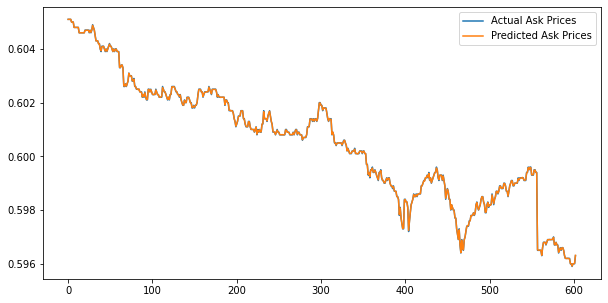

In [73]:
actual_prices = label_scaler.inverse_transform(test_df[label_columns].values)

test_predictions_aligned = actual_prices.copy()
test_predictions_aligned[20:, :] = test_predictions

plt.figure(figsize=(10, 5))
plt.plot(actual_prices[:,0], label='Actual Ask Prices')
plt.plot(test_predictions_aligned[:,0], label='Predicted Ask Prices')
plt.legend()
plt.show()